In [1]:
import heapq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
import seaborn as sns
import time
from IPython.core.display import display
from sklearn.linear_model import LinearRegression
from itertools import islice

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/VasiaPiven/covid19_ua/master/covid19_by_settlement_dynamics.csv')


In [3]:
data.groupby('registration_area').corr(method='pearson')

new_susp  new_confirm  active_confirm  \
registration_area                                                         
Івано-Франківська new_susp        1.000000     0.789205        0.751606   
                  new_confirm     0.789205     1.000000        0.703107   
                  active_confirm  0.751606     0.703107        1.000000   
                  new_death       0.386877     0.360289        0.361600   
                  new_recover     0.276904     0.305466        0.215585   
...                                    ...          ...             ...   
м. Київ           new_susp        1.000000     0.827711        0.695073   
                  new_confirm     0.827711     1.000000        0.720033   
                  active_confirm  0.695073     0.720033        1.000000   
                  new_death       0.426868     0.463728        0.610634   
                  new_recover     0.484797     0.456380        0.446264   

                                  new_death  new_recover  
registration_area                                         
Івано-Франківська new_susp         0.386877     0.276904  
                  new_confirm      0.360289     0.305466  
                  active_confirm   0.361600     0.215585  
                  new_death        1.000000     0.167179  
                  new_recover      0.167179     1.000000  
...                                     ...          ...  
м. Київ           new_susp         0.426868     0.484797  
                  new_confirm      0.463728     0.456380  
                  active_confirm   0.610634     0.446264  
                  new_death        1.000000     0.299934  
                  new_recover      0.299934     1.000000  

[125 rows x 5 columns]

In [4]:
pd.options.display.max_columns = None

In [5]:
def merge_areas():
    u = data['registration_area'].unique().tolist()
    d1 = data[(data['registration_area'] == u[0])].groupby('zvit_date').agg({'active_confirm':'sum'})
    for i in range(1, len(u)):
        d2 = data[(data['registration_area'] == u[i])].groupby('zvit_date').agg({'active_confirm':'sum'})
        d1 = d1.join(d2, lsuffix='_' + u[i-1],rsuffix='_' + u[i])
    d1.columns = u
    d1.replace(np.nan, 0, inplace=True)
    return d1

ma = merge_areas()
pd.options.display.max_columns = None
display(ma.head(20))

,Вінницька,Волинська,Дніпропетровська,Донецька,Житомирська,Закарпатська,Запорізька,Івано-Франківська,Київська,Кіровоградська,Луганська,Львівська,Миколаївська,м. Київ,Одеська,Полтавська,Рівненська,Сумська,Тернопільська,Харківська,Херсонська,Хмельницька,Черкаська,Чернівецька,Чернігівська
zvit_date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-12,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0
2020-03-15,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4,0.0
2020-03-16,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4,0.0
2020-03-17,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9,0.0
2020-03-18,0,0.0,0.0,1.0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9,0.0
2020-03-19,0,0.0,2.0,1.0,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,14,0.0
2020-03-20,0,0.0,2.0,1.0,1,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,19,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,24,0.0
2020-03-21,0,0.0,2.0,1.0,1,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,32,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,23,0.0
2020-03-22,0,0.0,2.0,1.0,1,0.0,0.0,4.0,5.0,0.0,0.0,1.0,0.0,37,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,23,0.0


In [6]:
ma.corr()

,Вінницька,Волинська,Дніпропетровська,Донецька,Житомирська,Закарпатська,Запорізька,Івано-Франківська,Київська,Кіровоградська,Луганська,Львівська,Миколаївська,м. Київ,Одеська,Полтавська,Рівненська,Сумська,Тернопільська,Харківська,Херсонська,Хмельницька,Черкаська,Чернівецька,Чернігівська
Вінницька,1.000000,0.992338,0.976978,0.966873,0.972806,0.923752,0.962826,0.948643,0.990025,0.916770,0.966614,0.962780,0.984578,0.987028,0.993510,0.960056,0.974158,0.963526,0.786125,0.994686,0.956419,0.990447,0.985321,0.966711,0.991912
Волинська,0.992338,1.000000,0.985972,0.981067,0.982110,0.934604,0.979454,0.959891,0.981857,0.943631,0.977975,0.961794,0.987023,0.977011,0.987561,0.974487,0.971587,0.981057,0.723404,0.992881,0.971488,0.993099,0.985782,0.976855,0.987504
Дніпропетровська,0.976978,0.985972,1.000000,0.985804,0.980791,0.894358,0.986008,0.942381,0.979951,0.957624,0.987986,0.922557,0.995753,0.955668,0.976779,0.989991,0.933700,0.981841,0.683055,0.985636,0.982516,0.989338,0.995954,0.973994,0.982147
Донецька,0.966873,0.981067,0.985804,1.000000,0.992130,0.928443,0.997144,0.972661,0.973891,0.977115,0.964788,0.936170,0.983250,0.929126,0.967495,0.993704,0.929500,0.989033,0.621811,0.980852,0.996986,0.983762,0.976562,0.986151,0.961949
Житомирська,0.972806,0.982110,0.980791,0.992130,1.000000,0.943504,0.992356,0.984086,0.982289,0.970309,0.956314,0.951725,0.984947,0.937591,0.979117,0.986241,0.950193,0.978948,0.667013,0.986329,0.993542,0.983763,0.974998,0.995893,0.964407
Закарпатська,0.923752,0.934604,0.894358,0.928443,0.943504,1.000000,0.925575,0.972095,0.916702,0.894475,0.870950,0.981823,0.905102,0.898378,0.928755,0.909357,0.959693,0.913298,0.637476,0.928905,0.924233,0.915024,0.887601,0.940932,0.893307
Запорізька,0.962826,0.979454,0.986008,0.997144,0.992356,0.925575,1.000000,0.974717,0.969734,0.983756,0.968602,0.931068,0.981495,0.929161,0.968502,0.992388,0.926618,0.991943,0.622296,0.979158,0.996445,0.984566,0.976212,0.986673,0.962596
Івано-Франківська,0.948643,0.959891,0.942381,0.972661,0.984086,0.972095,0.974717,1.000000,0.956329,0.953962,0.915410,0.959083,0.948381,0.913026,0.960533,0.959023,0.948882,0.961537,0.635517,0.965282,0.974367,0.958681,0.933446,0.985102,0.932167
Київська,0.990025,0.981857,0.979951,0.973891,0.982289,0.916702,0.969734,0.956329,1.000000,0.925512,0.953741,0.949757,0.988998,0.964352,0.990632,0.971073,0.957269,0.956763,0.761267,0.993122,0.971617,0.986114,0.986160,0.977573,0.981390
Кіровоградська,0.916770,0.943631,0.957624,0.977115,0.970309,0.894475,0.983756,0.953962,0.925512,1.000000,0.939974,0.882588,0.947351,0.872685,0.923591,0.970952,0.876444,0.974010,0.532288,0.938116,0.980778,0.950532,0.939293,0.969787,0.916510


In [7]:
def crosscorr(data, datax, datay, lag):
    corrs = 0
    index = 0
    for i in range((-(abs(lag))),(abs(lag)+1)):
        if i != 0:
            d1 = data[datax].shift(i)
            d2 = data[datay]
            cor = d1.corr(d2)
            if cor > corrs:
                corrs = cor
                index = i
        elif i == 0:
            d1 = data[datax]
            d2 = data[datay]
            cor = d1.corr(d2)
            if cor > corrs:
                corrs = cor
                index = i
    return corrs, index

In [8]:
crosscorr(data, 'active_confirm', 'new_death', 20)

(0.5053895930532367, 0)

In [9]:
u = merge_areas().columns.tolist()
l = len(u)
table_1 = pd.DataFrame(np.array([[0.0 for i in range(l)] for j in range(l)]), columns=u, index=u)
table_2 = pd.DataFrame(np.array([[0 for i in range(l)] for j in range(l)]), columns=u, index=u)

In [10]:
print(time.ctime())
col = ma.columns.tolist()
for i in col:
    for j in col:
        c = crosscorr(ma, i, j, 100)
        table_2[i][j] = c[1]
        table_1[i][j] = c[0]
        if i == j:
            table_2[i][j] = 0
            table_1[i][j] = 0
print(time.ctime())

Mon Nov 23 02:27:04 2020
Mon Nov 23 02:27:57 2020


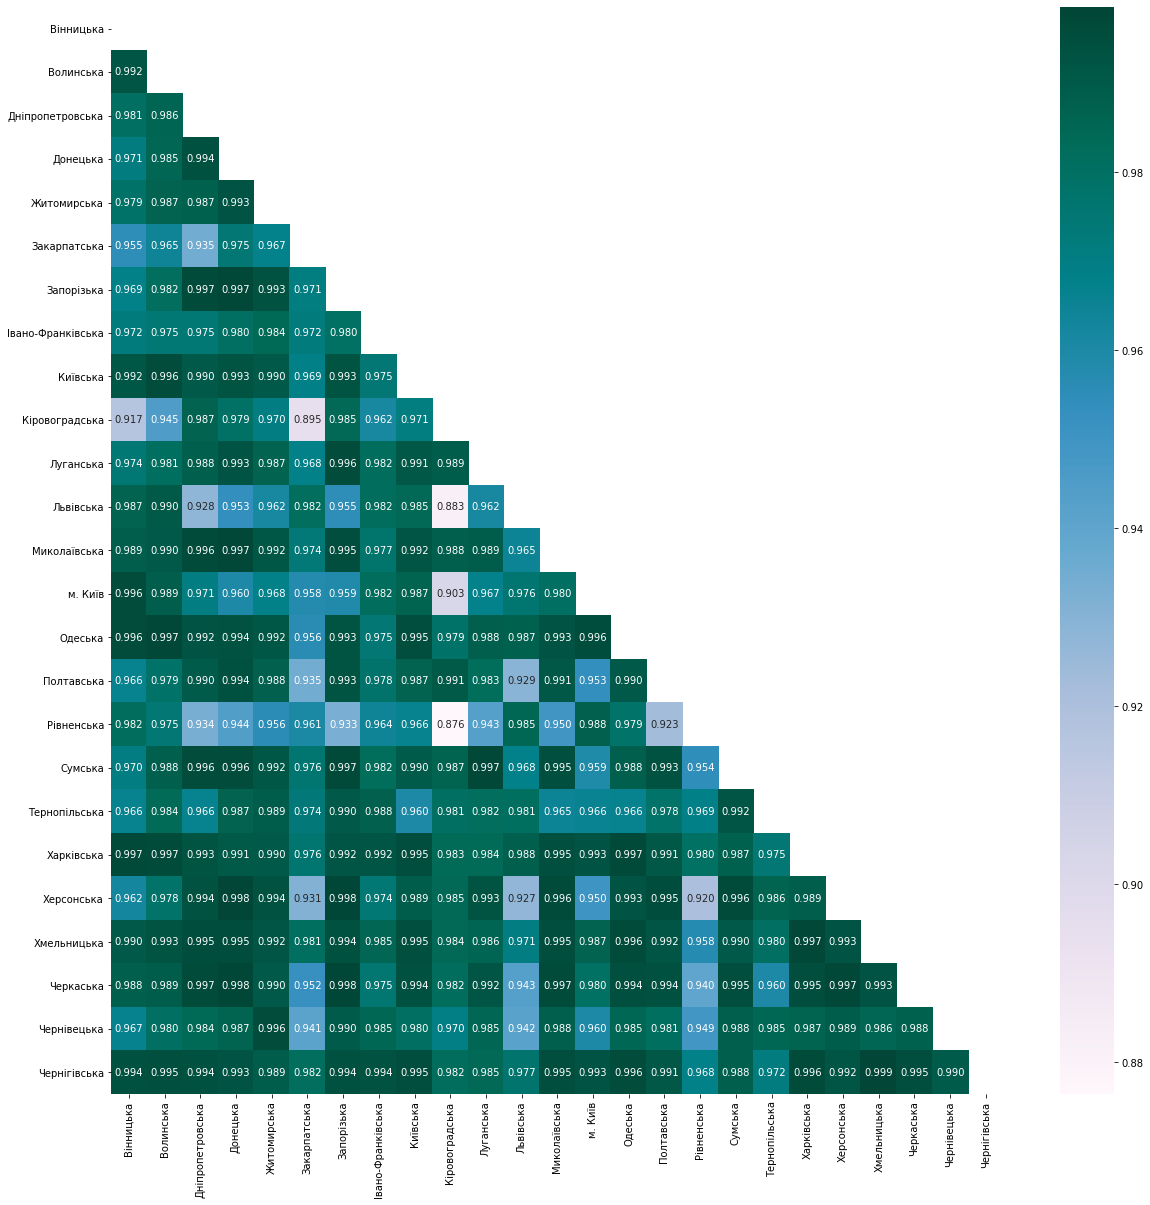

In [11]:
mask = np.zeros_like(table_1)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(table_1, annot=True,fmt='.3f', cmap = 'PuBuGn',mask = mask)
plt.show()

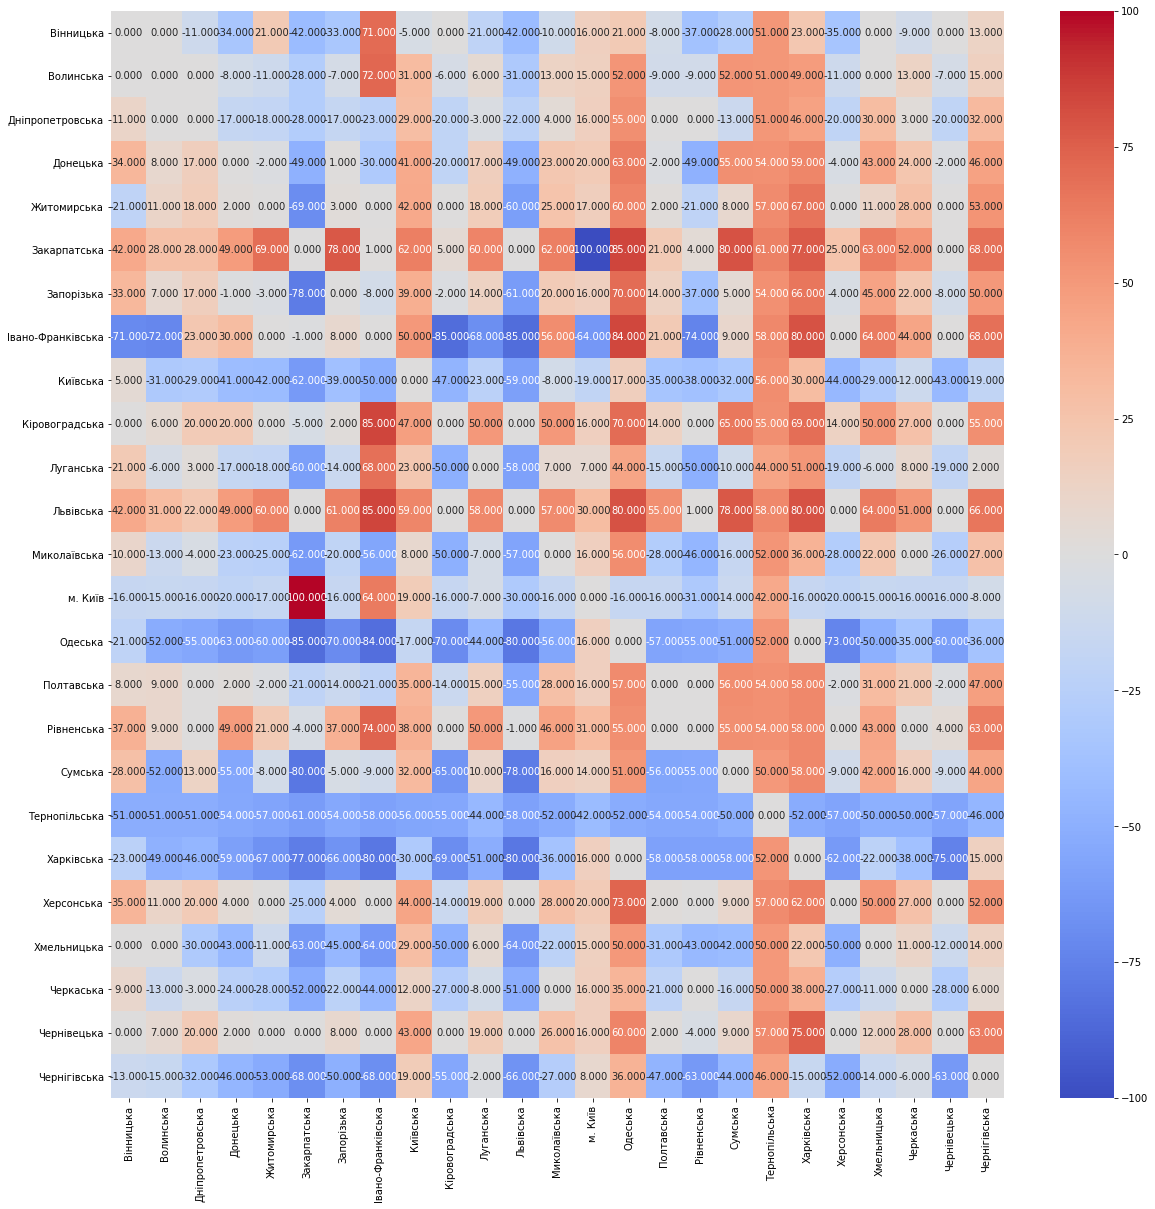

In [12]:
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(table_2, annot=True,fmt='.3f', center = 0, cmap='coolwarm')
plt.show()

In [13]:
col = table_2.columns.tolist()
count = 0
lider_dynamic = ''
for i in col:
    temp1 = 0
    temp2 = 0
    for j in col:
        if table_2[i][j] > 0:
            temp1 += 1
        elif table_2[i][j] < 0:
            temp2 += 1

        if temp1>count:
            count = temp1
            lider_dynamic = i
        elif temp2>count:
            count = temp2
            lider_dynamic = i
print("Лідер по динаміці: ", lider_dynamic)

Лідер по динаміці:  Тернопільська


In [14]:
max_corr_with_lider = table_1[lider_dynamic].idxmax()
max_corr_with_lider

'Сумська'

In [15]:
def prediction(data, values_for_x, values_for_y, days):
    # заповненя дааними
    reg = pd.DataFrame()
    reg_lag = table_2[values_for_x][values_for_y]
    reg['x'] = data[values_for_x].shift(reg_lag)
    reg['y'] = data[values_for_y]
    reg = reg.dropna()

    # представлення даних
    x1 = list(reg['x'])
    x = [[] for i in range(len(x1))]
    for i in range(len(x1)):
        x[i].append(x1[i])

    # вибір тестових і тренінгових даних
    x_train = x[:-days]
    x_test = x[-days:]
    y_train = reg['y'][:-days]
    y_test = reg['y'][-days:]

    # побудова передбачень
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)

    """plt.scatter(x_test, y_test, color ='pink')
    plt.plot(x_test, y_pred, color = 'r')
    plt.xlabel(values_for_x)
    plt.ylabel(values_for_y)"""

    return y_pred

In [33]:
pred = pd.DataFrame()
days = 7
for i in col:
    pred[lider_dynamic] = ma[lider_dynamic][-days:]
    pred[i] = prediction(ma, lider_dynamic, i, days)
pred

,Тернопільська,Вінницька,Волинська,Дніпропетровська,Донецька,Житомирська,Закарпатська,Запорізька,Івано-Франківська,Київська,Кіровоградська,Луганська,Львівська,Миколаївська,м. Київ,Одеська,Полтавська,Рівненська,Сумська,Харківська,Херсонська,Хмельницька,Черкаська,Чернівецька,Чернігівська
2020-11-14,4520.0,5229.476685,5927.032012,12109.904687,9160.394362,8810.946861,8376.475939,17607.406155,18238.363834,14584.096539,1800.307102,2020.104887,11841.125161,6927.705160,30346.975337,23064.205833,7754.754381,6127.699020,13931.831545,25776.337973,4008.838016,9870.694138,6766.343997,14180.299243,7638.938014
2020-11-15,4667.0,5177.817609,5865.904497,12004.102422,9321.275413,8991.048067,8732.633392,17914.097873,18585.080657,14605.973302,1811.948611,1972.845674,12004.889390,6842.269969,30419.507713,22714.421209,7872.840690,6200.008582,13648.597355,25355.993003,4095.865672,9702.775828,6691.101702,14477.243024,7517.399371
2020-11-16,4533.0,5104.996982,5779.736795,11854.959471,9140.462196,9006.596372,9136.879615,17569.408951,19039.737624,14680.718907,1844.033746,1973.987201,12219.636823,6785.991232,29495.674296,22484.007528,7740.124219,6118.740313,13859.207394,25079.099095,4103.378850,9827.638161,6747.051101,14502.878458,7335.091408
2020-11-17,4640.0,5159.145653,5843.810214,11965.860640,8961.072704,9059.719750,9380.329013,17227.434116,19078.988585,14886.725087,1807.973462,1978.325003,12238.176170,6706.658554,28476.403542,22159.207520,7608.452759,6038.111951,13384.729605,24688.778766,4129.048878,9546.339112,6621.004180,14590.466192,7141.564493
2020-11-18,4821.0,5037.155544,5699.460902,11716.014329,8842.903436,9206.132961,9539.623064,17002.164978,19213.096035,14655.196017,1772.197117,1923.075103,12301.518938,6765.649519,28010.669340,22400.725475,7521.716797,5984.999618,12963.509527,24979.016959,4199.797979,9296.614446,6509.105383,14831.866532,7146.239057
2020-11-19,4911.0,4928.858203,5571.314063,11494.211991,8676.327480,9041.580060,9748.508659,16684.616917,19582.709253,14425.490011,1748.630159,1862.117568,12476.097787,6632.750333,27865.604589,21856.616060,7399.450442,5910.130425,12648.804871,24325.147006,4120.283503,9110.038546,6425.502834,14560.558185,7164.002397
2020-11-20,5090.0,4847.946396,5475.572173,11328.497601,8800.191652,8878.322851,9766.541948,16920.742399,19167.303247,14274.175737,1715.409267,1834.264313,12279.889700,6514.768401,28732.175604,21373.580151,7490.366450,5965.802389,12176.747887,23744.670619,4041.395125,8830.174697,6300.099010,14291.386125,6937.753540


In [34]:
def convert(lst, var_lst):
    it = iter(lst)
    return [list(islice(it, i)) for i in var_lst]


var_lst = [5 for i in range(5)]
col_3_9 = convert(col, var_lst)
col_3_9

[['Вінницька', 'Волинська', 'Дніпропетровська', 'Донецька', 'Житомирська'],
 ['Закарпатська',
  'Запорізька',
  'Івано-Франківська',
  'Київська',
  'Кіровоградська'],
 ['Луганська', 'Львівська', 'Миколаївська', 'м. Київ', 'Одеська'],
 ['Полтавська', 'Рівненська', 'Сумська', 'Тернопільська', 'Харківська'],
 ['Херсонська', 'Хмельницька', 'Черкаська', 'Чернівецька', 'Чернігівська']]

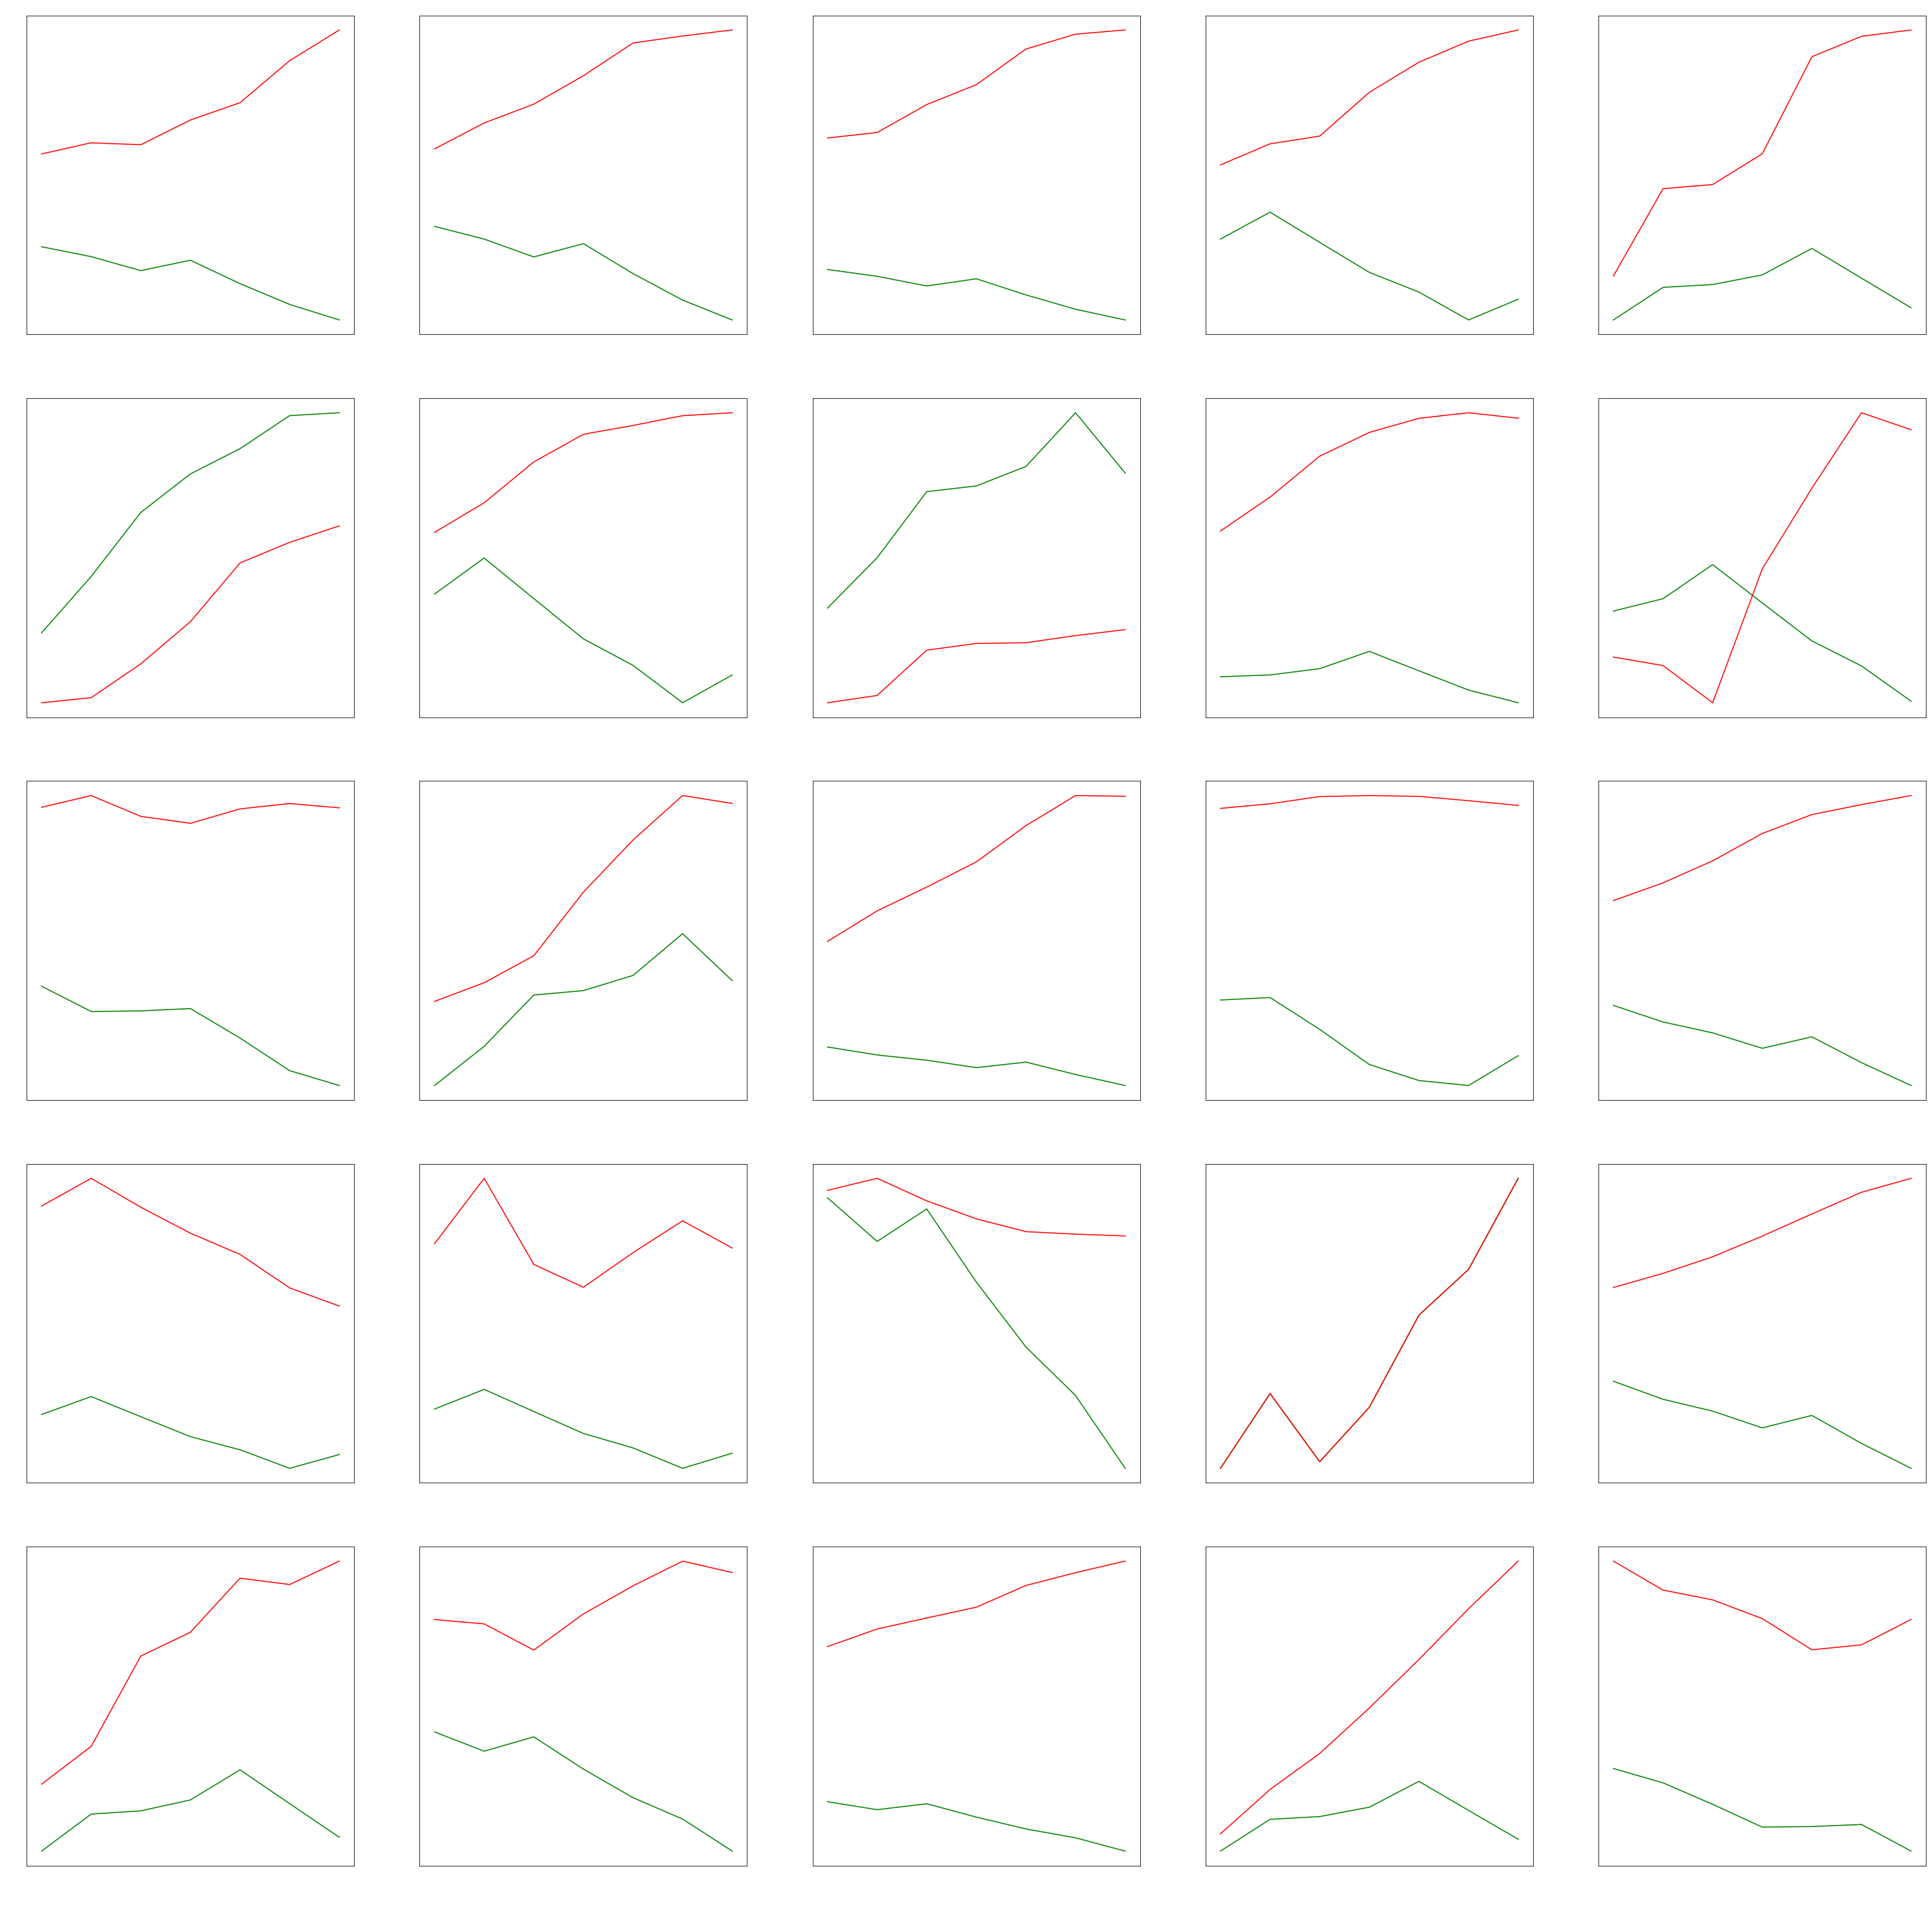

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (50,50))

for i in range(5):
    for j in range(5):
        axes[i, j].plot(pred.index, pred[(col_3_9[i][j])], color = 'g')
        axes[i, j].plot(pred.index, ma[(pred.index[0]):(pred.index[-1])][(col_3_9[i][j])], color = 'r')
        axes[i, j].set_title(col_3_9[j][i], color = 'w')
        axes[i, j].tick_params(labelrotation=45, colors = 'w')